# Single Population Spiking Grid Cell model

# Setup

## Basics

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import random
import math
import pandas as pd
import tqdm
import seaborn as sns

## CNS

In [2]:
from pymonntorch import *
from conex import *

# Random Walk

In [1445]:
WINDOW_WIDTH = 50
WINDOW_HEIGHT = 50

window_x = [-WINDOW_WIDTH/2, +WINDOW_WIDTH/2]
window_y = [-WINDOW_HEIGHT/2, +WINDOW_HEIGHT/2]

def conv(angel) : 
    x = np.cos(np.radians(angel))
    y = np.sin(np.radians(angel))

    return x, y

def random_walk(length, R = 20,  initialize = True) : 

    if(initialize) : 
        pos_x = [0]
        pos_y = [0]

    theta = 90
    cnt = 0
    length_cnt = 0

    for _ in range(length) : 

        dist = np.sqrt(pos_x[-1]**2 + pos_y[-1]**2)
        # print(dist)
        if(dist > R) : 
            ang = np.angle(complex(pos_x[-1], pos_y[-1]), deg = True)
            theta = ang + np.random.randint(90, 180) % 360

        pos_x.append(pos_x[-1] + (conv(theta)[0] + 6/5 * np.random.uniform(-0.5,0.5)) * 1/10)
        pos_y.append(pos_y[-1] + (conv(theta)[1] + 6/5 * np.random.uniform(-0.5,0.5)) * 1/10)
            
    return pos_x, pos_y
    

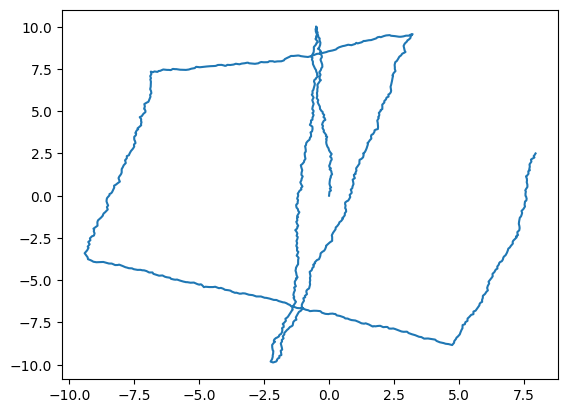

In [1463]:
pos_x, pos_y = random_walk(1000, R = 10)
plt.plot(pos_x, pos_y, '-')
plt.show()

# CONFIG

In [5]:
"""
Set of configuration of grid cells

Args : 
    N_COL (int): number of columns in 2D space of grid cells.
    N_ROW (int): number of rows in 2D space of grid cells.

    R (int): Radius of connectivity and neighboring neurons in grid cell plane.
    w (float) : the constant synaptic weight in grid cell plane to each other
"""
N_COL = 32
N_ROW = 32

R = 4
w = 1

# Behaviors

<Axes: >

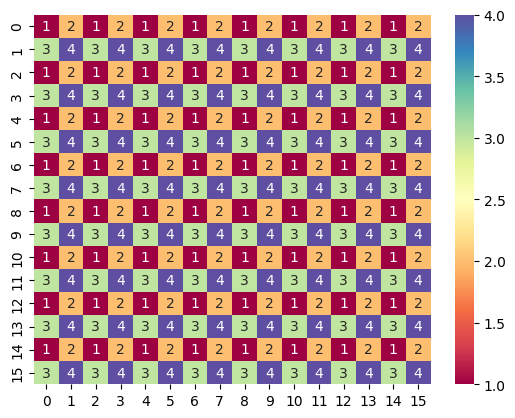

In [1259]:
ndir = []
for i in range(16) :
    ndir.append([])
    for j in range(16) :
        if(i % 2 == 0 and j % 2 == 0) :
            ndir[-1].append(1)
        if(i % 2 == 0 and j % 2 == 1) :
            ndir[-1].append(2)
        if(i % 2 == 1 and j % 2 == 0) :
            ndir[-1].append(3)
        if(i % 2 == 1 and j % 2 == 1) :
            ndir[-1].append(4)

sns.heatmap(ndir, annot=True, cmap='Spectral')

## GridCell neuron

In [6]:
class GridCell(Behavior) :

    def initialize(self, neurons) :
        """
        Set neuron attributes. and adds Fire function as attribute to population.

        Args:
            neurons (NeuronGroup): the neural population.
        """
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)

        neurons.v = self.parameter("init_v", neurons.vector())
        neurons.spikes = neurons.vector()

        neurons.spiking_neuron = self


        """
        Grid cell unique charactaristics.

        Arsgs :
            posX: x cordinate of each neuron in the 2D grid cell plane. [Implemented while using NeuronDimension]
            posY: y cordiante of each neuron in the 2D grid cell plane. [Implemented while using NeuronDimension]

            dir: unit vector of the desired direction of each neuron.
                [0, 1] -> N,
                [0, -1] -> S,
                [1, 0] -> E,
                [-1, 0] -> W
        """

        neurons.dir = torch.Tensor(neurons.size, 2)

        for i in range(neurons.NeuronDimension.height) :
            for j in range(neurons.NeuronDimension.width) :
                idx = i * neurons.NeuronDimension.height + j
                if(i % 2 == 0 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([0, 1])
                if(i % 2 == 0 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([0, -1])
                if(i % 2 == 1 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([1, 0])
                if(i % 2 == 1 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([-1, 0])

    def _RIu(self, neurons):
        """
        Part of neuron dynamic for voltage-dependent input resistance and internal currents.
        """
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        """
        Leakage dynamic
        """
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        """
        Basic firing behavior of spiking neurons:

        if v >= threshold then v = v_reset.
        """
        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):
        """
        Single step of dynamics.

        Args:
            neurons (NeuronGroup): the neural population.
        """
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )

        self.Fire(neurons)


In [23]:
        """
        what it should be : 
        """
        # for src in range(synapse.W.shape[0]) : 
        #     for dst in range(synapse.W.shape[1]) : 
        #         if(self.dist(synapse, src, dst) <= self.R) : 
        #             synapse.W[src, dst] = self.w

'\nwhat it should be : \n'

## GridCell synapse

In [7]:
class GridWeightInitializer(Behavior) :

    def initialize(self, synapse) :
        """
        Initialize the fixed synaptic weights in a grid cell plane based on a radius of connectivity.

        Args:
            R (int): Radius of connectivity and neighboring neurons in grid cell plane.
            w (float) : the constant synaptic weight in grid cell plane to each other.
            l (float) : Orientation prefence shift scaler.
        """

        self.R = self.parameter("R", required = True)
        self.w = self.parameter("w", required = True)
        self.l = self.parameter("l", required = True)

        synapse.W = synapse.matrix(mode = "zeros")

        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [DOWN]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        a = []
        for i in range(synapse.W.shape[0]) : 
            a.append([])
            for j in range(synapse.W.shape[1]) : 
                a[i].append(0)

        X = []
        Y = []
        Dir = []
        for i in synapse.src.x : 
            X.append(i.item())
                    
        for i in synapse.src.y : 
            Y.append(i.item())
        
        for i in synapse.src.dir : 
            Dir.append([])
            for j in range(2) : 
                Dir[-1].append(i[j].item())

        MOD = (max(synapse.src.x).item() * 2 + 1)

        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [UP]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        for S in tqdm.tqdm(range(len(a))) :
            for D in range(len(a)) :
                distance = math.sqrt((X[S] - X[D] - Dir[S][0])**2 + (Y[S] - Y[D] - Dir[S][1])**2)

                if(distance <= self.R or MOD - distance <= self.R) :
                    a[S][D] = self.w

        synapse.W = torch.Tensor(a)
        


    def dist(self, synapse, S, D) :
        """
        computes the euclidian distance between two 'S' and 'D' neurons in the grid cell plane.

        Args :
            synapse (SynapseGroup) : synapse group of the grid cell to itself.
            S (int) : index of the source neuron in grid cell neuron group.
            D (int) : index of the destination neuron in grid cell neuron group.
        """

        return (synapse.src.x[S] - synapse.dst.x[D] - synapse.src.dir[S][0])**2 + (synapse.src.y[S] - synapse.dst.y[D] - synapse.src.dir[S][1])**2

In [8]:
class GridDendriteInput(Behavior) :

    def initialize(self, neurons) :
        """
        convert the given random walk into speed vector and input current of grid cells.

        Args:
            I_ext (float) : External Input Current which is a constant feedforward throughout the simulation.
            I_vel (float) : Velocity current scaler.
            a (float) : envelope function coefficient.
            walk (tuple) : Tuple of (x, y) of positions in the random walk of length the size of simulation.
            orientation (float) : degree of orientation of the grid cell plane.
            offset_x (float) : offset of the origin of the grid cell plane X-axis.
            offset_y (float) : offset of the origin of the grid cell plane Y-axis.
        """

        self.I_ext = self.parameter("I_ext", 2.4)
        self.I_vel = self.parameter("I_vel", 0.175)
        self.a = self.parameter("a", 4)
        self.walk = self.parameter("walk", None, required = True)

        self.orientation = self.parameter("orientation", 0)
        self.offset_x = self.parameter("offset_x", 0)
        self.offset_y = self.parameter("offset_y", 0)

        neurons.I = neurons.vector(mode = self.I_ext)

    def forward(self, neurons) :
        itr = neurons.network.iteration

        prev = [0, 0]
        if(itr != 0) : prev = [self.walk[0][itr - 1], self.walk[1][itr - 1]]

        curr = [self.walk[0][itr], self.walk[1][itr]]

        speed_vector = torch.Tensor([curr[0] - prev[0], curr[1] - prev[1]])
        speed_vector = self.rotate(speed_vector)

        neurons.I = (self.I_ext + self.I_vel * (speed_vector[0] * (neurons.x + self.offset_x) + speed_vector[1] * (neurons.y + self.offset_y))) * self.f(neurons)

    def f(self, neurons) :
        return torch.exp(-self.a * torch.sqrt(neurons.x**2 + neurons.y**2)/neurons.NeuronDimension.height)

    def rotate(self, speed_vector) : 
        phi = torch.tensor(self.orientation * math.pi / 180)
        s = torch.sin(phi)
        c = torch.cos(phi)
        rot = torch.stack([torch.stack([c, -s]),
                        torch.stack([s, c])])

        return speed_vector @ rot.t()

# Synapse Function

In [9]:
class SynFun(Behavior) : 

    def initialize(self, sg) : 
        # sg.W = sg.matrix(mode="normal(0.5, 0.3)")
        sg.I = sg.dst.vector()

    def forward(self, sg) :
        sg.I = torch.sum(sg.W[sg.src.spikes], axis = 0)

In [10]:
class SynInp(Behavior) : 
    
    def forward(self, ng) : 
        for syn in ng.afferent_synapses["All"] : 
            ng.I += syn.I

# Visualization

In [11]:
def spike_range(ng, L, R) :
    return ng['spikes', 0][torch.logical_and(ng['spikes', 0][:, 0] >= L, ng['spikes', 0][:, 0] < R)][:,1]

In [12]:
def plot_range(ng, L, R) :
    plt.plot(pos_x[L:R], pos_y[L:R], '-')
    plt.plot(ng.x[spike_range(ng, L, R)] * 25/25, ng.y[spike_range(ng, L, R)] * 25/25, 'o', color = 'red')
    plt.show()

In [13]:
def find_walk(ng, pos_x, pos_y, x = 0, y = 0, R = 2) :
    idx = []
    for i in range(len(pos_x)):
        if( (pos_x[i] - x)**2 + (pos_y[i] - y)**2 <= R**2) :
            idx.append(i)

    return idx

In [968]:
ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == 150][:,1]


E = []
W = []
N = []
S = []
for idx in ng_idx :
    i = idx//64
    j = idx%64

    if(i % 2 == 0 and j % 2 == 0) :
        N.append(idx)
    if(i % 2 == 0 and j % 2 == 1) :
        S.append(idx)
    if(i % 2 == 1 and j % 2 == 0) :
        E.append(idx)
    if(i % 2 == 1 and j % 2 == 1) :
        W.append(idx)

print(E)
print(W)
print(N)
print(S)

ng.x[[]]

[]
[tensor(95), tensor(97), tensor(99), tensor(127), tensor(497), tensor(499), tensor(501), tensor(625), tensor(627), tensor(629), tensor(753), tensor(755), tensor(991), tensor(993), tensor(1115), tensor(1117), tensor(1119), tensor(1121), tensor(1123), tensor(1243), tensor(1245), tensor(1247), tensor(1249), tensor(1251), tensor(1279), tensor(1373), tensor(1375), tensor(1377), tensor(1407), tensor(1533), tensor(1535), tensor(1663), tensor(1737), tensor(1739), tensor(1741), tensor(1775), tensor(1777), tensor(1865), tensor(1867), tensor(1869), tensor(1901), tensor(1903), tensor(1905), tensor(1907), tensor(1991), tensor(1993), tensor(1995), tensor(1997), tensor(2029), tensor(2031), tensor(2033), tensor(2035), tensor(2121), tensor(2143), tensor(2157), tensor(2159), tensor(2161), tensor(2163), tensor(2269), tensor(2271), tensor(2273), tensor(2395), tensor(2397), tensor(2399), tensor(2401), tensor(2523), tensor(2525), tensor(2527), tensor(2529), tensor(2651), tensor(2653), tensor(2655), tenso

tensor([])

In [1469]:
def iter_spike(ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs") :
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]

    
    E = []
    W = []
    N = []
    S = []
    for idx in ng_idx :
        i = idx//64
        j = idx%64

        if(i % 2 == 0 and j % 2 == 0) :
            N.append(idx.item())
        if(i % 2 == 0 and j % 2 == 1) :
            S.append(idx.item())
        if(i % 2 == 1 and j % 2 == 0) :
            E.append(idx.item())
        if(i % 2 == 1 and j % 2 == 1) :
            W.append(idx.item())
    
    # print(E)
    # print(W)
    # print(N)
    # print(S)

    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    # plt.plot(pos_X * -1, pos_Y * -1, color = 'gray', alpha = 0.4)
    plt.plot(pos_X[prev:itr*step] * -1, pos_Y[prev:itr*step] * -1, color = 'black')
    
    plt.plot(ng.x[E] *(50 / (max(ng.x)*2 + 1)), ng.y[E] * (50 / (max(ng.x)*2 + 1)),'o',color = 'blue', markersize = (4 * scale/(ng.shape.width)) + 2)
    plt.plot(ng.x[W] *(50 / (max(ng.x)*2 + 1)), ng.y[W] * (50 / (max(ng.x)*2 + 1)),'o',color = 'red', markersize = (4 * scale/(ng.shape.width)) + 2)
    plt.plot(ng.x[N] *(50 / (max(ng.x)*2 + 1)), ng.y[N] * (50 / (max(ng.x)*2 + 1)),'o',color = 'green', markersize = (4 * scale/(ng.shape.width)) + 2)
    plt.plot(ng.x[S] *(50 / (max(ng.x)*2 + 1)), ng.y[S] * (50 / (max(ng.x)*2 + 1)),'o',color = 'yellow', markersize = (4 * scale/(ng.shape.width)) + 2)

    plt.legend(["path", "W", "E", "S", "N", "loc"], loc = 'upper right')


    plt.plot(pos_x[itr*step] * -1, pos_y[itr*step]* -1, '.', color = 'red')

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

In [1488]:
itr = 100

this_iter_idx = ng["spikes", 0][:, 0] == itr
first_depth_idx = ng["spikes", 0][:, 1] < 40*40

neurons_true_false = torch.logical_and(this_iter_idx, first_depth_idx)

neurons_idx = ng["spikes", 0][neurons_true_false][:,1]
neurons_idx_itr = ng["spikes", 0][neurons_true_false][:,0]

print(neurons_idx)
print(neurons_idx_itr)

tensor([   0,    2,   14,   16,   18,   20,   42,   44,   46,   48,   62,  128,
         130,  144,  146,  172,  174,  188,  190,  256,  258,  286,  288,  316,
         318,  384,  386,  388,  412,  414,  416,  444,  446,  512,  514,  540,
         542,  544,  546,  668,  670,  672,  674,  796,  798,  800,  910,  912,
         914,  940,  942,  944, 1036, 1038, 1040, 1042, 1066, 1068, 1070, 1072,
        1164, 1166, 1168, 1170, 1194, 1196, 1198, 1200, 1294, 1296, 1298, 1322,
        1324, 1326, 1328, 1408, 1468, 1470, 1536, 1538, 1564, 1566, 1568, 1570,
        1594, 1596, 1598])
tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 

In [1436]:
def iter_spike_multi_subplot(ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs", label = "grid", offset_x = 0, offset_y = 0, base_offset_x = 0, base_offset_y = 0) :
    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]


    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    plt.figure(figsize = (10, 3))

    plt.subplot(1, 2, 1)
    plt.title("Grid Module Spikes")
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)
    plt.plot((ng.x[ng_idx] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, label = label)
    plt.legend(loc = 'upper right')

    
    plt.subplot(1, 2, 2)
    plt.title("Rat Movement")
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)
    plt.plot((pos_X[:itr*step] + base_offset_x) * -1, (pos_Y[:itr*step] + base_offset_y) * -1, color = 'gray', alpha = 0.5)
    plt.plot((pos_X[prev:itr*step] + base_offset_x) * -1, (pos_Y[prev:itr*step] + base_offset_y) * -1, color = 'black')
    plt.plot((pos_x[itr*step] + base_offset_x) * -1, (pos_y[itr*step] + base_offset_y)* -1, '^', color = 'red', markersize = 10)
    
    plt.suptitle(f"iteration = {itr * step}", y = -0.01)

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

In [1479]:
def iter_spike_multi(ng, itr, save = False, step = False, color = 'red', scale = 50, lib = "figs", label = "grid", offset_x = 0, offset_y = 0, base_offset_x = 0, base_offset_y = 0) :
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    prev = max(0, itr*step - 30)

    ng_idx = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step][:,1]
    ng_idx_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 4][:,1]
    ng_idx_prev_prev = ng["spikes", 0][ng["spikes", 0][:, 0] == itr * step - 8][:,1]

    pos_X = torch.Tensor(pos_x)
    pos_Y = torch.Tensor(pos_y)

    plt.plot((pos_X[prev:itr*step] + base_offset_x) * -1, (pos_Y[prev:itr*step] + base_offset_y) * -1, color = 'gray')
    
    plt.plot((ng.x[ng_idx_prev_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.2)
    plt.plot((ng.x[ng_idx_prev] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx_prev] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, alpha = 0.35)
    plt.plot((ng.x[ng_idx] + offset_x) *(50 / (max(ng.x)*2 + 1)), (ng.y[ng_idx] + offset_y) * (50 / (max(ng.x)*2 + 1)),'o',color = color, markersize = (4 * scale/(ng.shape.width)) + 2, label = label)
    plt.legend(loc = 'upper right')

    plt.plot((pos_x[itr*step] + base_offset_x) * -1, (pos_y[itr*step] + base_offset_y)* -1, '^', color = 'red', markersize = 10)

    plt.title(f"iteration = {itr * step}", y = -0.2)
    plt.suptitle("Grid Module Spikes")

    if(save) :
        plt.savefig("{}/fig{}.png".format(lib, itr))

In [399]:
def pos_walk(ng, pos_x, pos_y, x = 0, y = 0, R = 1, save = False, itr = 0, step = 1, color = 'red', scale = 50) :

    if(x == -1 and y == -1) :
        x = pos_x[itr * step]
        y = pos_y[itr * step]

    idx = find_walk(ng, pos_x, pos_y, x, y, R)

    ng_idx = set()
    for spike in ng['spikes', 0][:] :
        if(spike[0] in idx) :
            ng_idx.add(spike[1].item())

    ng_idx = list(ng_idx)

    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

    plt.plot(ng.x[ng_idx] *(50 / (max(ng.x)*2 + 1)), ng.y[ng_idx] * (50 / (max(ng.x)*2 + 1)),'o', color = color, markersize = (4 * scale/(ng.shape.width)) + 2)
    plt.plot(pos_x[:itr*step], pos_y[:itr*step], color = 'black')
    plt.plot(pos_x[itr*step], pos_y[itr*step], '.', color = 'black')

    if(save) :
        plt.savefig("figs/fig{}.png".format(itr))
    # plt.show()

In [15]:
def most_spike_plot(ng, threshold = 10, color = 'red', scale = 50) : 
    cnt = ng.vector('zeros')

    for spike in ng['spikes', 0] :
        cnt[spike[1]] += 1
    
    plt.plot(ng.x[cnt > threshold] *(50 / (max(ng.x)*2 + 1)), ng.y[cnt > threshold]*(50 / (max(ng.x)*2 + 1)),'o', color = color, markersize = (4 * scale/(ng.shape.width)) + 3)
    plt.xlim(-25, +25)
    plt.ylim(-25, +25)

In [33]:
# pos_walk(ng, pos_x, pos_y,x = -1, y = -1, R = 2, save = False, itr = 10, step = 5, color = 'red')
# most_spike_plot(ng, 20)

# Network Construction

In [901]:
net = Network(behavior={
    1 : TimeResolution(dt = 1)
})

ng = NeuronGroup(size = NeuronDimension(width = 50, height = 50), net = net, behavior={
    2 : GridDendriteInput(walk = (pos_x, pos_y)),
    3 : SynInp(),
    4 : GridCell(
        R = 2,
        tau = 10,
        threshold = -63,
        v_rest = -65,
        v_reset = -67 
    ),

    9 : Recorder(['v', 'I']),
    10 : EventRecorder(['spikes'])
})

sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
    5 : GridWeightInitializer(R = 10, w = -1.6, l = 2),
    6 : SynFun()
})

# Simulation

In [35]:
net.initialize()
for i in range(10) : 
    net.simulate_iterations(100)

Network['Network'](Neurons: tensor(2500)|1 groups, Synapses: tensor(6250000)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](2500){0:NeuronDimension(depth=1,height=50,width=50,input_patterns=None,)2:GridDendriteInput(walk=([0, 0.43267983605641974, 0.8032877499260012, 1.1466187451898808, 1.6131270367807915, 1.9833259987019405, 1.5818335389406744, 1.4087031587110248, 1.8612274664382662, 1.642424610654008, 1.1835940450049178, 1.1017446728810398, 1.4339398573427928, 1.8383601379774719, 2.329063156507544, 2.783105821686024, 3.1854193595041815, 3.25703886431094, 2.930638934365756, 2.960743418634964, 3.3404514260154645, 3.1339721932816658, 3.2922804070485068, 3.002766637744773, 3.0142876509621748, 2.52308953099734, 2.1762735387744008, 1.9507814871474625, 1.6123768309217756, 1.4704194548764724, 1.1657891092753756, 1.1951234814626006, 0.8513533554380388, 0.5122334293627733, 0.6630537467691943, 0.5631484236279792, 0.5070142724954586, 0.34517271655622095, -0.0

# Orientation & Scales & Offset

In [429]:
net = Network(behavior={
    1 : TimeResolution(dt = 1)
})

offset_x = torch.rand(6) * 8 - 4
offset_y = torch.rand(6) * 8 - 4

ngs = []
for i in range(6) : 
    ng = NeuronGroup(size = NeuronDimension(width = 5, height = 5), net = net, behavior={
        2 : GridDendriteInput(
            walk = (pos_x, pos_y),
            a = 2, 
            orientation = 60*i,
            offset_x = offset_x[i], 
            offset_y = offset_y[i],
            I_ext = 1.6,
            I_vel = 0.3
        ),
        3 : SynInp(),
        4 : GridCell(
            R = 10,
            tau = 10,
            threshold = -63,
            v_rest = -65,
            v_reset = -67
        ),

        10 : EventRecorder(['spikes'])
    })

    ngs.append(ng)

    sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
        5 : GridWeightInitializer(R = 8, w = -4.6, l = 2),
        6 : SynFun()
    })

# for i in range(3) : 
#     ng = NeuronGroup(size = NeuronDimension(width = 25, height = 25), net = net, behavior={
#         2 : GridDendriteInput(walk = (pos_x, pos_y), a = 2, orientation = i*120 - 60),
#         3 : SynInp(),
#         4 : GridCell(
#             R = 10,
#             tau = 10,
#             threshold = -63,
#             v_rest = -65,
#             v_reset = -67
#         ),

#         10 : EventRecorder(['spikes'])
#     })

#     ngs.append(ng)

#     sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
#         5 : GridWeightInitializer(R = 4, w = -3.6, l = 2),
#         6 : SynFun()
#     })

# for i in range(3) : 
#     ng = NeuronGroup(size = NeuronDimension(width = 100, height = 100), net = net, behavior={
#         2 : GridDendriteInput(walk = (pos_x, pos_y), a = 2, orientation = i*120 - 30),
#         3 : SynInp(),
#         4 : GridCell(
#             R = 10,
#             tau = 10,
#             threshold = -63,
#             v_rest = -65,
#             v_reset = -67
#         ),

#         10 : EventRecorder(['spikes'])
#     })

#     ngs.append(ng)

#     sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
#         5 : GridWeightInitializer(R = 16, w = -3.6, l = 2),
#         6 : SynFun()
#      })

In [430]:
net.initialize()
for i in range(6) : 
    net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(150)|6 groups, Synapses: tensor(3750)|6 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](25){0:NeuronDimension(depth=1,height=5,width=5,input_patterns=None,)2:GridDendriteInput(walk=([0, -0.4279441512497671, -0.0600943885755264, 0.0924630203814864, -0.277128547530736, -0.6133648957888593, -0.9855560473152986, -1.1850120715972627, -0.7735167019086797, -0.8454332207657885, -1.0271914075249566, -0.733636543947419, -0.6969350142853226, -0.41956197901000747, -0.1222841147145976, -0.334368644218209, -0.4372369658495087, -0.6388525961494105, -0.25116982027504176, -0.6278506164523678, -0.8739154798158533, -0.3771175577124013, -0.7918559076689322, -0.7953632271143695, -1.4647425223936823, -1.080155712953784, -0.7124026254832403, -0.5007501078584862, 0.16887878137521328, 0.11732431923042597, 0.6029700066323362, 0.38652663365670825, 0.6606600760553827, 1.1230176752060714, 1.4815200992398836, 1.4018057139097466, 1.936995580845841

100%|██████████| 25/25 [00:00<00:00, 12545.78it/s]


1000xBatch: 1/1 (100%) 4018.664ms
1000xBatch: 1/1 (100%) 2768.177ms
1000xBatch: 1/1 (100%) 2692.935ms
1000xBatch: 1/1 (100%) 2650.730ms
1000xBatch: 1/1 (100%) 2702.437ms
1000xBatch: 1/1 (100%) 2739.898ms


## Visualize

In [17]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = list(prop_cycle.by_key()['color'])

# # ord = [3, 4, 5, 0, 1, 2, 6, 7, 8]
# thre = [30, 20, 10]
# cnt = 0

# # plt.plot(pos_x, pos_y, color = 'gray')
# for ng in ngs : 
#     most_spike_plot(ng, 32, color = colors[cnt], scale = 50)
#     cnt += 1
#     # if(cnt == ) : 
#     #     break

#     # if(cnt%3 == 2) :
#     plt.show()    


In [432]:
# prop_cycle = plt.rcParams['axes.prop_cycle']
# colors = list(prop_cycle.by_key()['color'])

# for i in range(0, 25) :
#     cnt = 0
#     for ng in ngs : 
#         pos_walk(ng, pos_x, pos_y,x = -1, y = -1, R = 2, save = False, itr = i, step = 3, scale = 50, color = colors[cnt])
#         cnt += 1
#         if(cnt == 2) : 
#             break
#     plt.show()

## Visualize Backward
(Points in the plane with only one grid cell)

In [435]:
net = Network(behavior={
    1 : TimeResolution(dt = 1)
})

offset_x = torch.rand(6) * 8 - 4
offset_y = torch.rand(6) * 8 - 4

ngs = []
for i in range(6) : 
    ng = NeuronGroup(size = NeuronDimension(width = 5, height = 5), net = net, behavior={
        2 : GridDendriteInput(
            walk = (pos_x, pos_y),
            a = 2, 
            orientation = 60*i,
            offset_x = offset_x[i], 
            offset_y = offset_y[i],
            I_ext = 1.6,
            I_vel = 0.3
        ),
        3 : SynInp(),
        4 : GridCell(
            R = 10,
            tau = 10,
            threshold = -63,
            v_rest = -65,
            v_reset = -67
        ),

        10 : EventRecorder(['spikes'])
    })

    ngs.append(ng)

    sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
        5 : GridWeightInitializer(R = 8, w = 0, l = 2),
        6 : SynFun()
    })

# for i in range(3) : 
#     ng = NeuronGroup(size = NeuronDimension(width = 25, height = 25), net = net, behavior={
#         2 : GridDendriteInput(walk = (pos_x, pos_y), a = 2, orientation = i*120 - 60),
#         3 : SynInp(),
#         4 : GridCell(
#             R = 10,
#             tau = 10,
#             threshold = -63,
#             v_rest = -65,
#             v_reset = -67
#         ),

#         10 : EventRecorder(['spikes'])
#     })

#     ngs.append(ng)

#     sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
#         5 : GridWeightInitializer(R = 4, w = -3.6, l = 2),
#         6 : SynFun()
#     })

# for i in range(3) : 
#     ng = NeuronGroup(size = NeuronDimension(width = 100, height = 100), net = net, behavior={
#         2 : GridDendriteInput(walk = (pos_x, pos_y), a = 2, orientation = i*120 - 30),
#         3 : SynInp(),
#         4 : GridCell(
#             R = 10,
#             tau = 10,
#             threshold = -63,
#             v_rest = -65,
#             v_reset = -67
#         ),

#         10 : EventRecorder(['spikes'])
#     })

#     ngs.append(ng)

#     sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GABA', behavior={
#         5 : GridWeightInitializer(R = 16, w = -3.6, l = 2),
#         6 : SynFun()
#      })

In [436]:
net.initialize()
for i in range(6) : 
    net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(150)|6 groups, Synapses: tensor(3750)|6 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](25){0:NeuronDimension(depth=1,height=5,width=5,input_patterns=None,)2:GridDendriteInput(walk=([0, -0.4279441512497671, -0.0600943885755264, 0.0924630203814864, -0.277128547530736, -0.6133648957888593, -0.9855560473152986, -1.1850120715972627, -0.7735167019086797, -0.8454332207657885, -1.0271914075249566, -0.733636543947419, -0.6969350142853226, -0.41956197901000747, -0.1222841147145976, -0.334368644218209, -0.4372369658495087, -0.6388525961494105, -0.25116982027504176, -0.6278506164523678, -0.8739154798158533, -0.3771175577124013, -0.7918559076689322, -0.7953632271143695, -1.4647425223936823, -1.080155712953784, -0.7124026254832403, -0.5007501078584862, 0.16887878137521328, 0.11732431923042597, 0.6029700066323362, 0.38652663365670825, 0.6606600760553827, 1.1230176752060714, 1.4815200992398836, 1.4018057139097466, 1.936995580845841

100%|██████████| 25/25 [00:00<?, ?it/s]


1000xBatch: 1/1 (100%) 3310.093ms
1000xBatch: 1/1 (100%) 3217.760ms
1000xBatch: 1/1 (100%) 2915.386ms
1000xBatch: 1/1 (100%) 3710.912ms
1000xBatch: 1/1 (100%) 4874.600ms
1000xBatch: 1/1 (100%) 4793.544ms


In [526]:

# for i in range(25) : 
#     spike_pos = neuron["spikes", 0][neuron["spikes", 0][:, 1] == i, 0]
#     Px = torch.Tensor(pos_x)
#     Py = torch.Tensor(pos_y)
#     plt.plot(Px[spike_pos], Py[spike_pos], 'o')
#     plt.show()

# TODO-LIST

* What is the input?
* How to integrate the input
* Too many neurons ?? 
* what exactly should from a hexagonal shape? neurons?? or the place in the natural grid when only one neuron fires???

In [793]:
class GridCell2(Behavior) :

    def initialize(self, neurons) :
        """
        Set neuron attributes. and adds Fire function as attribute to population.

        Args:
            neurons (NeuronGroup): the neural population.
        """
        self.add_tag(self.__class__.__name__)

        neurons.R = self.parameter("R", None, required=True)
        neurons.tau = self.parameter("tau", None, required=True)
        neurons.threshold = self.parameter("threshold", None, required=True)
        neurons.v_reset = self.parameter("v_reset", None, required=True)
        neurons.v_rest = self.parameter("v_rest", None, required=True)

        neurons.v = neurons.vector(self.parameter("init_v", 0))

        neurons.spiking_neuron = self


        """
        Grid cell unique charactaristics.

        Arsgs :
            posX: x cordinate of each neuron in the 2D grid cell plane. [Implemented while using NeuronDimension]
            posY: y cordiante of each neuron in the 2D grid cell plane. [Implemented while using NeuronDimension]

            dir: unit vector of the desired direction of each neuron.
                [0, 1] -> N,
                [0, -1] -> S,
                [1, 0] -> E,
                [-1, 0] -> W
        """

        neurons.dir = torch.Tensor(neurons.size, 2)

        for i in range(neurons.NeuronDimension.height) :
            for j in range(neurons.NeuronDimension.width) :
                idx = i * neurons.NeuronDimension.height + j
                if(i % 2 == 0 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([0, 1])
                if(i % 2 == 0 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([0, -1])
                if(i % 2 == 1 and j % 2 == 0) :
                    neurons.dir[idx] = torch.Tensor([1, 0])
                if(i % 2 == 1 and j % 2 == 1) :
                    neurons.dir[idx] = torch.Tensor([-1, 0])

    def _RIu(self, neurons):
        """
        Part of neuron dynamic for voltage-dependent input resistance and internal currents.
        """
        return neurons.R * neurons.I

    def _Fu(self, neurons):
        """
        Leakage dynamic
        """
        return neurons.v_rest - neurons.v

    def Fire(self, neurons):
        """
        Basic firing behavior of spiking neurons:

        if v >= threshold then v = v_reset.
        """
        neurons.spikes = neurons.v >= neurons.threshold
        neurons.v[neurons.spikes] = neurons.v_reset

    def forward(self, neurons):

        if(neurons.network.iteration < 10) : 
            neurons.spikes = neurons.vector(0)

            x = torch.Tensor([ 151,  153,  279,  281,  515,  517, 1173, 1175, 1177, 1179, 1301, 1303,
                1305, 1307, 1367, 1369, 1427, 1429, 1431, 1433, 1435, 1465, 1467, 1469,
                1531, 1557, 1559, 1561, 1563, 1591, 1593, 1595, 1597, 1599, 1687, 1689,
                1723, 1827, 1829, 1831, 1833, 1835, 1953, 1955, 1957, 1959, 1961, 1963,
                2023, 2025, 2051, 2053, 2079, 2081, 2083, 2085, 2087, 2089, 2091, 2093,
                2149, 2151, 2153, 2179, 2181, 2209, 2211, 2213, 2215, 2217, 2219, 2279,
                2337, 2339, 2341, 2343, 2345, 2347, 2469, 2471, 2581, 2583, 2585, 2707,
                2709, 2711, 2713, 2747, 2749, 2751, 2773, 2775, 2835, 2837, 2839, 2841,
                2875, 2877, 2879, 2901, 2963, 2965, 2967, 2969, 3459, 3461, 3497, 3499,
                3501, 3585, 3587, 3589, 3591, 3625, 3627, 3629, 3651, 3653, 3713, 3715,
                3717, 3719, 3755, 3779, 3781, 3841, 3843, 3845, 3847, 3907, 3969, 3971,
                3973, 3991, 3993, 3995, 4029, 4031])

            x = x.type(torch.int32)
                
            neurons.spikes[x] += True
            neurons.v += (
                (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
            )
            return

        """
        Single step of dynamics.

        Args:
            neurons (NeuronGroup): the neural population.
        """
        neurons.v += (
            (self._Fu(neurons) + self._RIu(neurons)) * neurons.network.dt / neurons.tau
        )

        neurons.v = torch.maximum(neurons.v, torch.Tensor([-1000]))

        self.Fire(neurons)


In [764]:
x = torch.Tensor([ 151,  153,  279,  281,  515,  517, 1173, 1175, 1177, 1179, 1301, 1303,
        1305, 1307, 1367, 1369, 1427, 1429, 1431, 1433, 1435, 1465, 1467, 1469,
        1531, 1557, 1559, 1561, 1563, 1591, 1593, 1595, 1597, 1599, 1687, 1689,
        1723, 1827, 1829, 1831, 1833, 1835, 1953, 1955, 1957, 1959, 1961, 1963,
        2023, 2025, 2051, 2053, 2079, 2081, 2083, 2085, 2087, 2089, 2091, 2093,
        2149, 2151, 2153, 2179, 2181, 2209, 2211, 2213, 2215, 2217, 2219, 2279,
        2337, 2339, 2341, 2343, 2345, 2347, 2469, 2471, 2581, 2583, 2585, 2707,
        2709, 2711, 2713, 2747, 2749, 2751, 2773, 2775, 2835, 2837, 2839, 2841,
        2875, 2877, 2879, 2901, 2963, 2965, 2967, 2969, 3459, 3461, 3497, 3499,
        3501, 3585, 3587, 3589, 3591, 3625, 3627, 3629, 3651, 3653, 3713, 3715,
        3717, 3719, 3755, 3779, 3781, 3841, 3843, 3845, 3847, 3907, 3969, 3971,
        3973, 3991, 3993, 3995, 4029, 4031])

x = x.type(torch.int32)

ng["v", 0][0, x]

tensor([[   1,    0],
        [   1,    2],
        [   1,    4],
        ...,
        [   1, 4010],
        [   1, 4012],
        [   1, 4014]])

In [1363]:
class GridDendriteInput2(Behavior) :

    def initialize(self, neurons) :
        """
        convert the given random walk into speed vector and input current of grid cells.

        Args:
            I_ext (float) : External Input Current which is a constant feedforward throughout the simulation.
            I_vel (float) : Velocity current scaler.
            a (float) : envelope function coefficient.
            walk (tuple) : Tuple of (x, y) of positions in the random walk of length the size of simulation.
            orientation (float) : degree of orientation of the grid cell plane.
            offset_x (float) : offset of the origin of the grid cell plane X-axis.
            offset_y (float) : offset of the origin of the grid cell plane Y-axis.
        """

        self.I_ext = self.parameter("I_ext", 1)
        self.I_vel = self.parameter("I_vel", 0.175)
        self.a = self.parameter("a", 4)
        self.walk = self.parameter("walk", None, required = True)

        self.orientation = self.parameter("orientation", 0)
        self.offset_x = self.parameter("offset_x", 0)
        self.offset_y = self.parameter("offset_y", 0)

        neurons.I = neurons.vector(mode = self.I_ext)

    def forward(self, neurons) :
        itr = neurons.network.iteration

        prev = [0, 0]
        if(itr != 0) : prev = [self.walk[0][itr - 1], self.walk[1][itr - 1]]

        curr = [self.walk[0][itr], self.walk[1][itr]]

        speed_vector = torch.Tensor([curr[0] - prev[0], curr[1] - prev[1]])

        prev_vec = self.vector_resize(copy.deepcopy(speed_vector))
        speed_vector = self.rotate(speed_vector)
        speed_vector = self.vector_resize(speed_vector)
        
        neurons.I = (neurons.vector(f"normal({self.I_ext}, {0})") + self.I_vel * (speed_vector[0] * (neurons.dir[:, 0]) + speed_vector[1] * (neurons.dir[:, 1]))) * self.envelope(neurons)
        # if(itr < 20) : 
        #     print(prev_vec)
        #     print(speed_vector)
        #     print(speed_vector)
        #     print((speed_vector[0] * (neurons.dir[2080, 0]) + speed_vector[1] * (neurons.dir[2080, 1])))

    def envelope(self, neurons) :
        return torch.exp(-self.a * torch.sqrt(neurons.x**2 + neurons.y**2)/neurons.NeuronDimension.height)

    def relu(self, x) :
        return torch.maximum(x, torch.Tensor([0]))

    def rotate(self, speed_vector) : 
        phi = torch.tensor(self.orientation * math.pi / 180)
        s = torch.sin(phi)
        c = torch.cos(phi)
        rot = torch.stack([torch.stack([c, -s]),
                        torch.stack([s, c])])

        return speed_vector @ rot.t()

    def vector_resize(self, vel) : 
        sz = np.sqrt(vel[0]**2 + vel[1]**2)
        return vel/sz

In [725]:
ng["spikes", 0]

tensor([[   1,    0],
        [   1,    2],
        [   1,    4],
        ...,
        [1000, 4009],
        [1000, 4011],
        [1000, 4034]])

In [1081]:
class GridWeightInitializer2(Behavior) :

    def initialize(self, synapse) :
        """
        Initialize the fixed synaptic weights in a grid cell plane based on a radius of connectivity.

        Args:
            R (int): Radius of connectivity and neighboring neurons in grid cell plane.
            w (float) : the constant synaptic weight in grid cell plane to each other.
            l (float) : Orientation prefence shift scaler.
        """

        self.R = self.parameter("R", required = True)
        self.l = self.parameter("l", required = True)
        self.a = self.parameter("a", 1)
        self.beta = self.parameter("beta", 0.2)
        self.gamma = self.parameter("gamma", 1.05)

        synapse.W = synapse.matrix(mode = "zeros")

        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [DOWN]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        a = []
        for i in range(synapse.W.shape[0]) : 
            a.append([])
            for j in range(synapse.W.shape[1]) : 
                a[i].append(0)

        X = []
        Y = []
        Dir = []
        for i in synapse.src.x : 
            X.append(i.item())
                    
        for i in synapse.src.y : 
            Y.append(i.item())
        
        for i in synapse.src.dir : 
            Dir.append([])
            for j in range(2) : 
                Dir[-1].append(i[j].item())


        """
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        What in the actual fuck !!!!!! [UP]
        ------------------------------------------------------------------------------
        ------------------------------------------------------------------------------
        """

        for S in tqdm.tqdm(range(len(a))) :
            for D in range(len(a)) :
                x = X[S] - X[D] - self.l * Dir[S][0]
                y = Y[S] - Y[D] - self.l * Dir[S][1]

                sz_squared = x*x + y*y
                metric = 3/(13*13)

                a[S][D] = self.a * np.exp(-self.gamma * metric * sz_squared) - np.exp(-self.beta * metric * sz_squared)


        synapse.W = torch.Tensor(a) * self.R

        
    def W0(self, x, y) :
        metric = 3/(13*13)
        
        return self.a * np.exp(-self.gamma * metric * sz_squared) - np.exp(-self.beta * metric * sz_squared)


    def dist(self, synapse, S, D) :
        """
        computes the euclidian distance between two 'S' and 'D' neurons in the grid cell plane.

        Args :
            synapse (SynapseGroup) : synapse group of the grid cell to itself.
            S (int) : index of the source neuron in grid cell neuron group.
            D (int) : index of the destination neuron in grid cell neuron group.
        """

        return (synapse.src.x[S] - synapse.dst.x[D] - synapse.src.dir[S][0])**2 + (synapse.src.y[S] - synapse.dst.y[D] - synapse.src.dir[S][1])**2

In [1464]:
net = Network(behavior={
    1 : TimeResolution(dt = 1)
})

offset_x = torch.rand(6) * 0
offset_y = torch.rand(6) * 0

Rs = [120, 5,6, 6, 6, 3]
Bs = [1, 0.15, 0.3, 0.7 ,0.6, 0.3]
Gs = [1.05, 1.05, 1.05, 1.15, 1.05, 1.02]

ngs = []
for i in range(1) : 
    ng = NeuronGroup(size = NeuronDimension(width = 64, height = 64), net = net, behavior={
        2 : GridDendriteInput2(
            walk = (pos_x, pos_y),
            a = 2, 
            orientation = 0,
            offset_x = offset_x[i], 
            offset_y = offset_y[i],
            I_ext = 15,
            I_vel = 25
        ),
        3 : SynInp(),
        4 : GridCell(
            R = 10,
            tau = 5,
            threshold = -63,
            v_rest = -65,
            v_reset = -67,
            init_v = -65
        ),

        9 : Recorder(["I", "v"]),
        10 : EventRecorder(['spikes'])
    })

    ngs.append(ng)

    sg = SynapseGroup(net = net, src = ng, dst = ng, tag = 'GLUTAMATE', behavior={
        5 : GridWeightInitializer2(R = Rs[0], a = 1, beta = Bs[0], gamma = Gs[0], l = 2),
        6 : SynFun()
    })

In [1465]:
net.initialize()
for i in range(1) : 
    net.simulate_iterations(1000)

Network['Network'](Neurons: tensor(4096)|1 groups, Synapses: tensor(16777216)|1 groups){1:TimeResolution(dt=1,)}
NeuronGroup['NeuronGroup_1', 'NeuronGroup', 'ng'](4096){0:NeuronDimension(depth=1,height=64,width=64,input_patterns=None,)2:GridDendriteInput2(walk=([0, 0.006746842152474777, 0.015787370965971055, 0.07210004337754039, 0.02975351958063857, 0.0785201319224096, 0.04015637416599552, 0.016859014612074584, 0.024552052011275045, 0.038907279320461105, 0.06960873659697103, 0.06247725019989709, 0.0814624359360666, 0.11687230353164642, 0.09842743438173879, 0.08766948030818184, 0.07271079136393477, 0.020468766911868864, 0.0698531697033409, 0.028075599240275938, 0.0033945333305904282, 0.03550684856412795, 0.0626369637347706, 0.103032110853695, 0.09128400853664657, 0.04221392064568676, 0.10012523852721719, 0.040980116844912054, -0.0004497147805330448, -0.013839478178247624, -0.02184723126508012, -0.06513990989247959, -0.10119607148774895, -0.11072739142253485, -0.09519548792462647, -0.115

100%|██████████| 4096/4096 [00:41<00:00, 98.76it/s] 


1000xBatch: 1/1 (100%) 9198.159ms


In [1371]:
a = torch.Tensor([1, 2])
b = copy.deepcopy(a)
a[0] = 2
print(a, b)

tensor([2., 2.]) tensor([1., 2.])


In [512]:
ng["I", 0]

tensor([[  1.0214,   0.9884,   1.0668,  ...,   1.0398,   1.0149,   0.9955],
        [-54.5506, -57.5326, -60.4668,  ..., -60.3608, -57.4175, -54.5232],
        [  1.0194,   0.9905,   1.0647,  ...,   1.0380,   1.0166,   0.9938],
        ...,
        [ -3.7471,  -3.3062,  -3.1323,  ...,   1.0326,   1.0219,   0.9886],
        [  0.9691,   1.0404,   1.0116,  ...,   1.0101,   0.9972,   0.9672],
        [  0.9526,   1.0286,   0.9950,  ...,   0.7385,   0.7731,   0.7737]])

In [ ]:
torch.min(sg.W), torch.max(sg.W)

(tensor(-0.1794), tensor(0.))

tensor([-1.,  0.])


<Axes: >

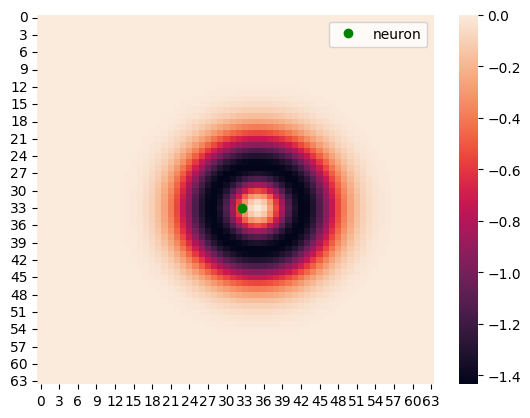

In [1310]:
W_base = sg.W[2080 + 65].view((ng.width, ng.height))
print(ng.dir[2080 + 65])
plt.plot((2080 + 65)%64, (2080 + 65)/64,'o', color = 'green', label = "neuron")
plt.legend()
sns.heatmap(W_base)

In [1390]:
ng_I = ng["v", 0][420, :].view((ng.width, ng.height))
ng_I.shape

torch.max(ng_I)

sns.heatmap(ng_I)

<Axes: >

In [1391]:
ng_I = ng["I", 0][250, :].view((ng.width, ng.height))
ng_I.shape

torch.max(ng_I)

sns.heatmap(ng_I)

<Axes: >

In [465]:

# for i in range(ngs[0].size) : 
#     neuron = ngs[0]
#     pos_spike = neuron["spikes", 0][neuron["spikes", 0][:, 1] == i][:, 0]
#     if(len(pos_spike) < 625) : 
#         continue

#     Px = torch.Tensor(pos_x)
#     Py = torch.Tensor(pos_y)
#     plt.plot(Px[pos_spike], Py[pos_spike], 'o')
#     plt.show()
#     # neuron["spikes", 0][:, 1][25:50]

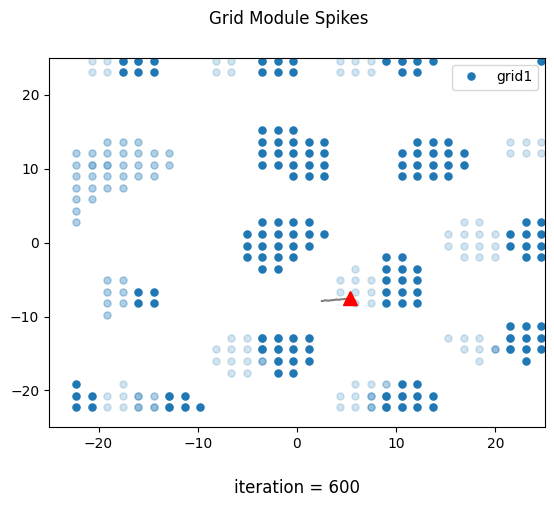

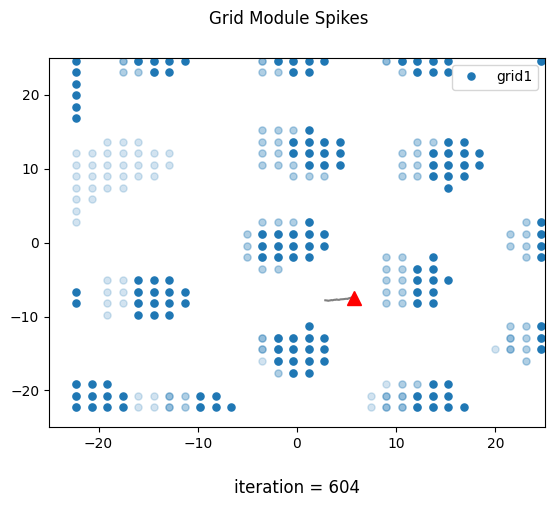

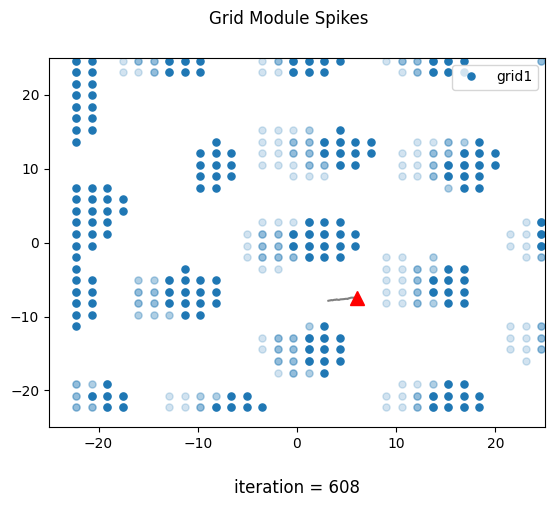

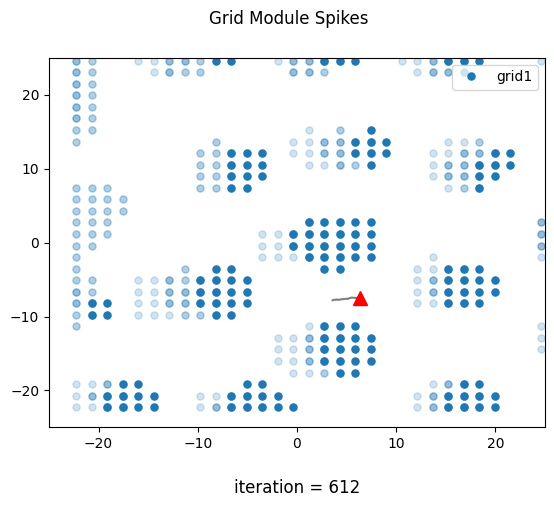

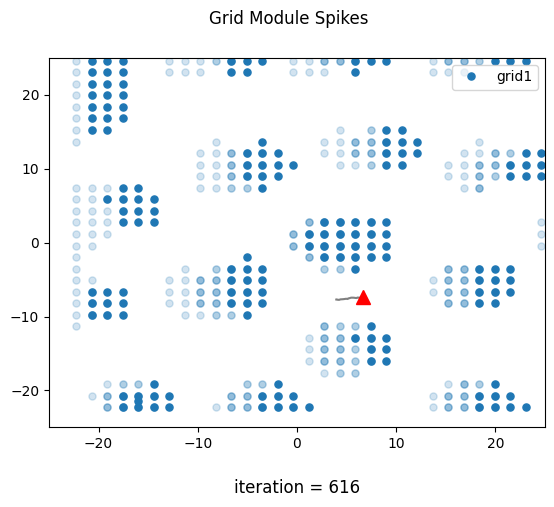

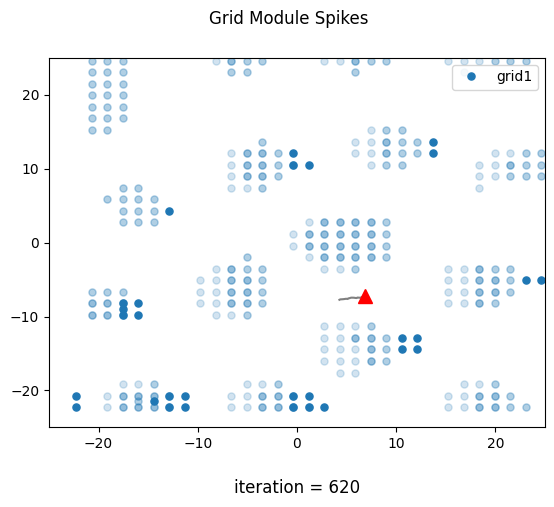

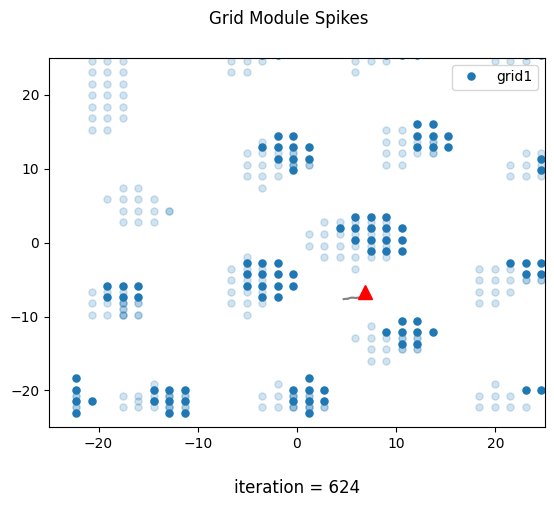

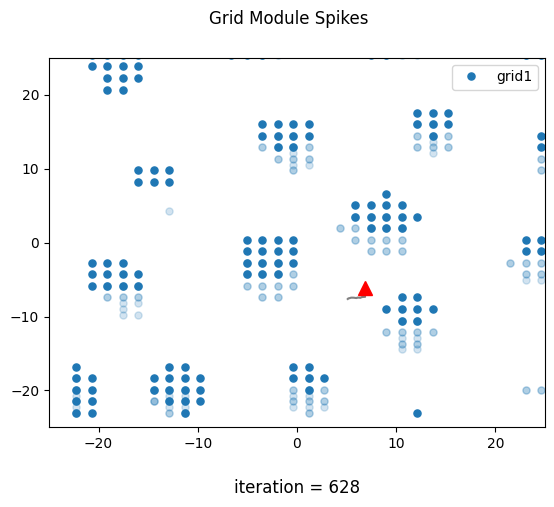

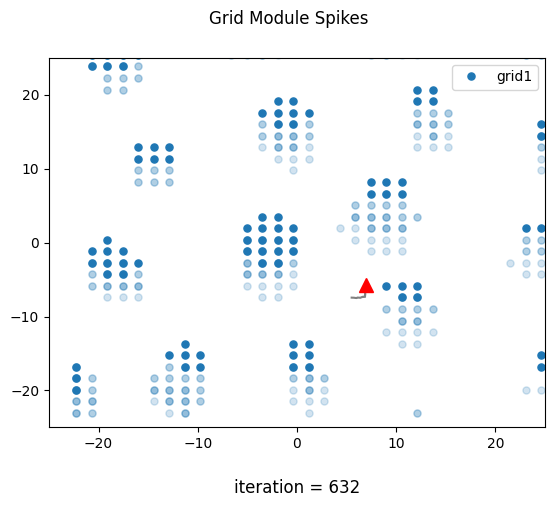

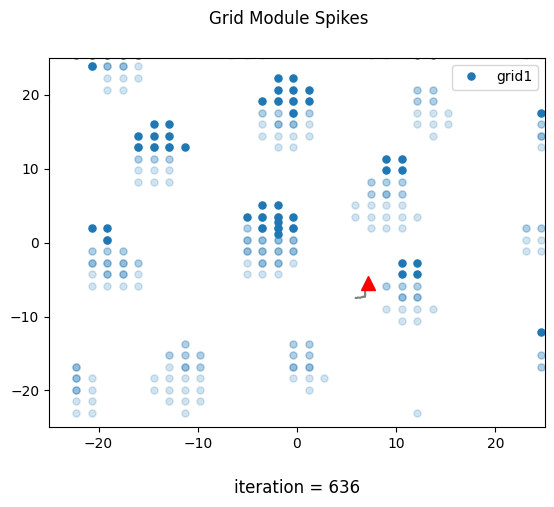

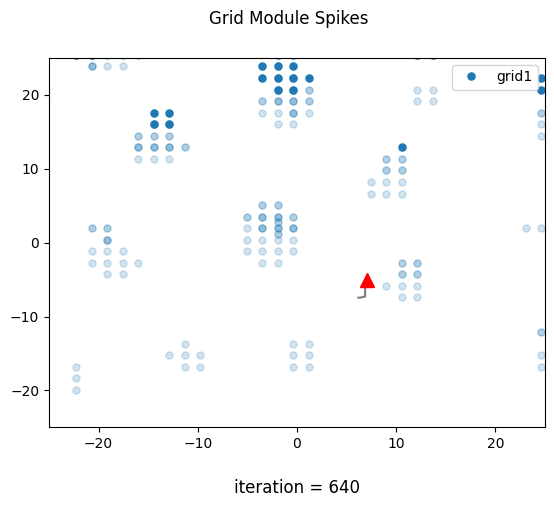

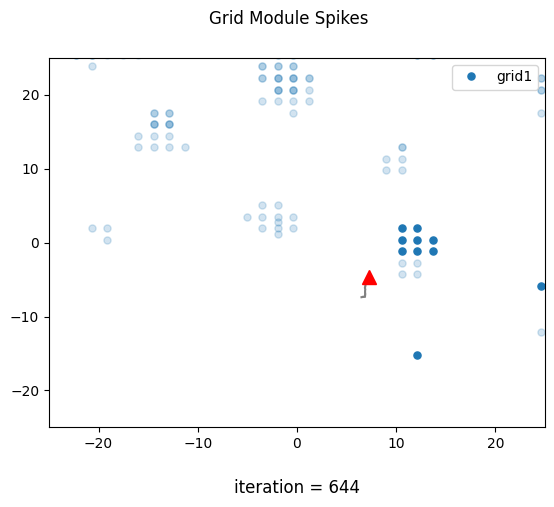

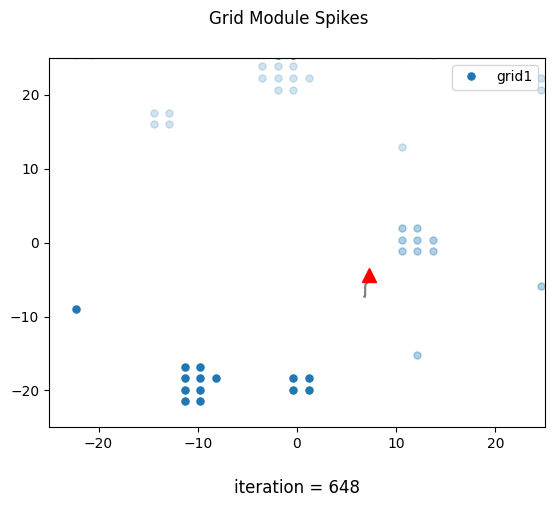

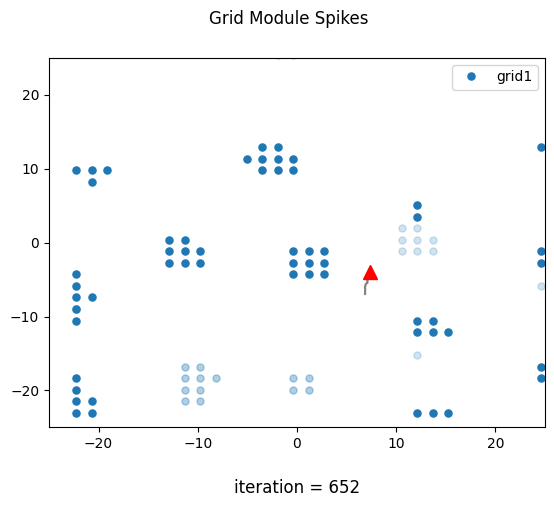

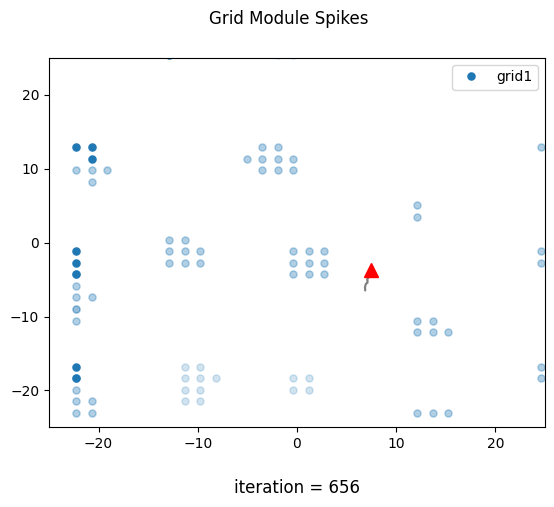

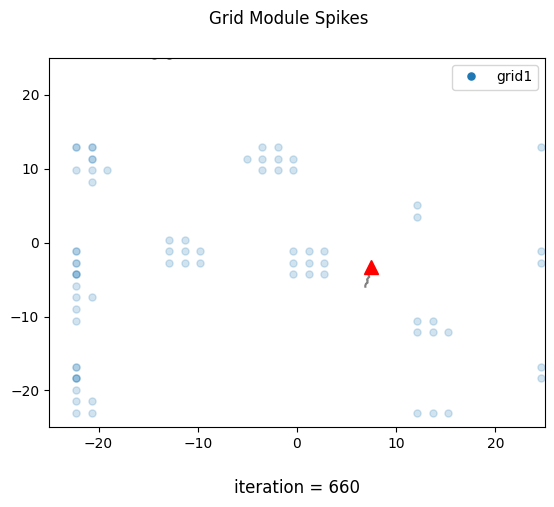

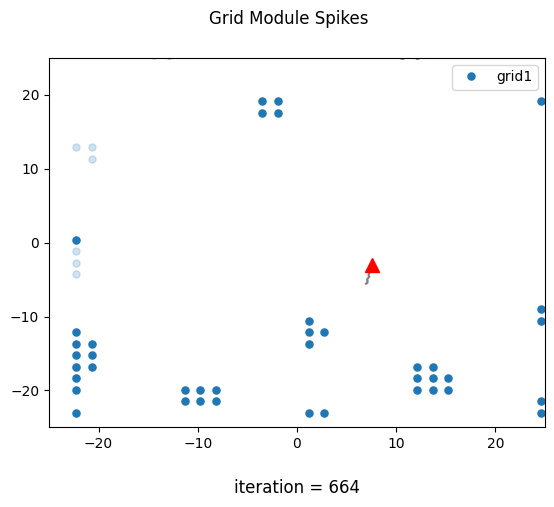

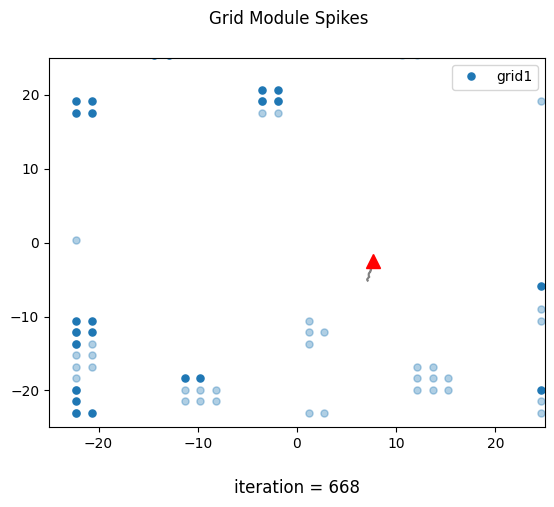

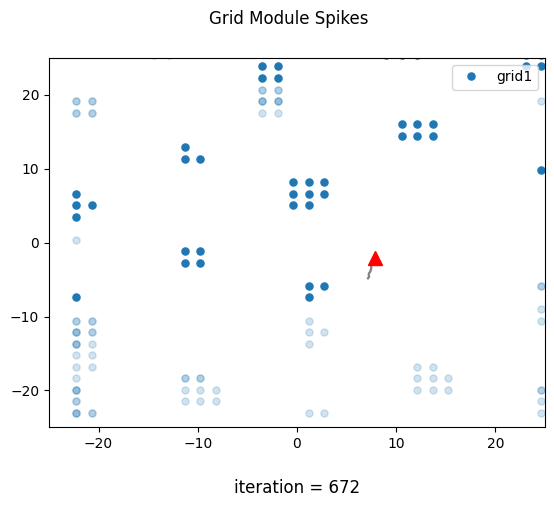

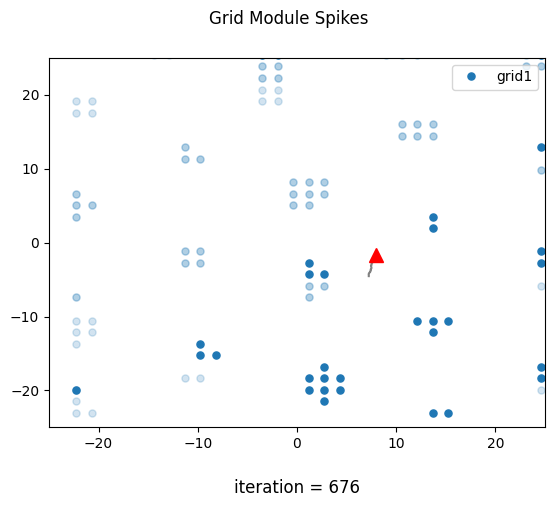

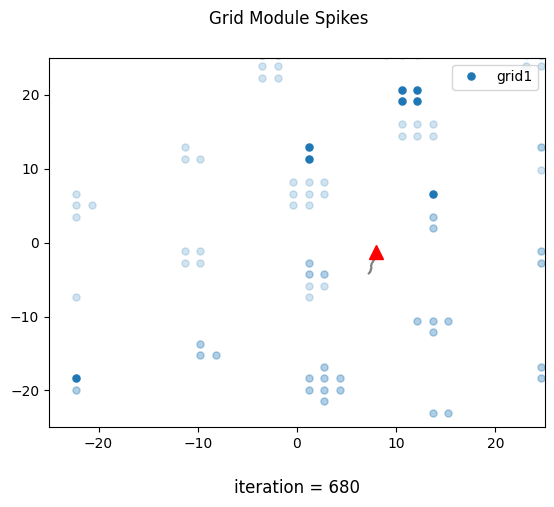

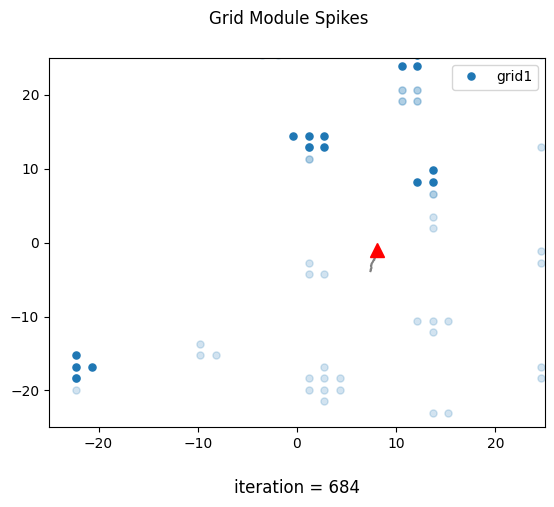

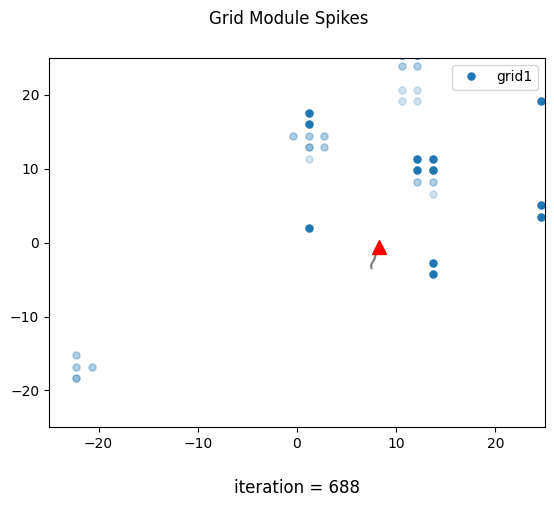

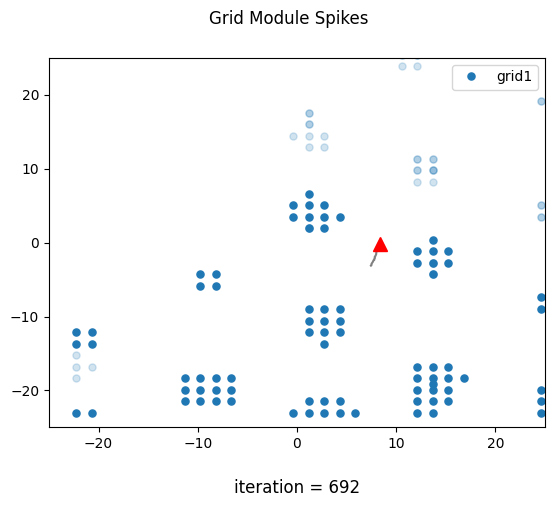

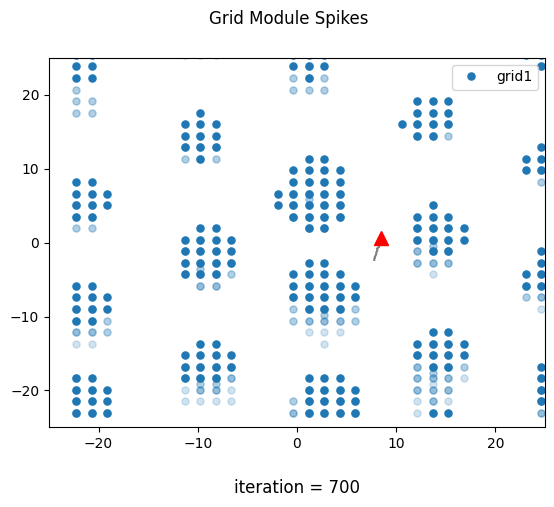

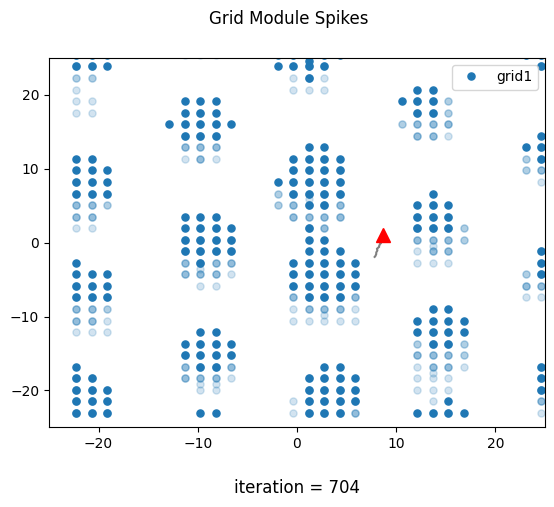

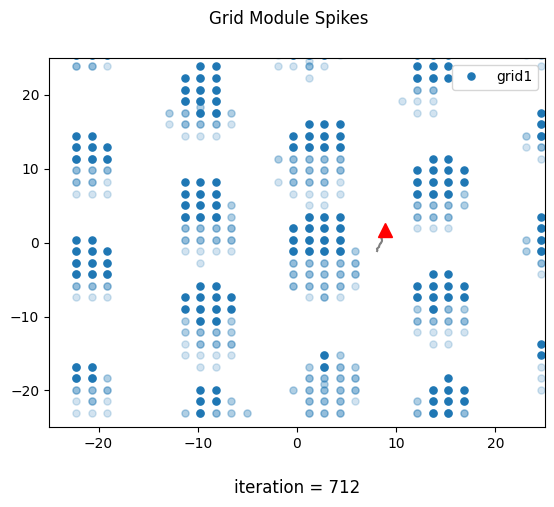

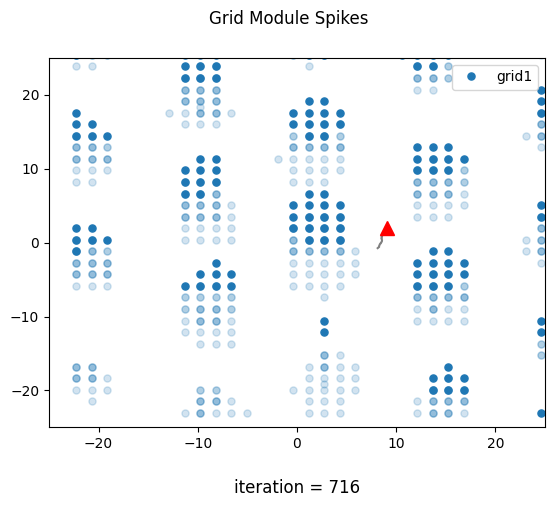

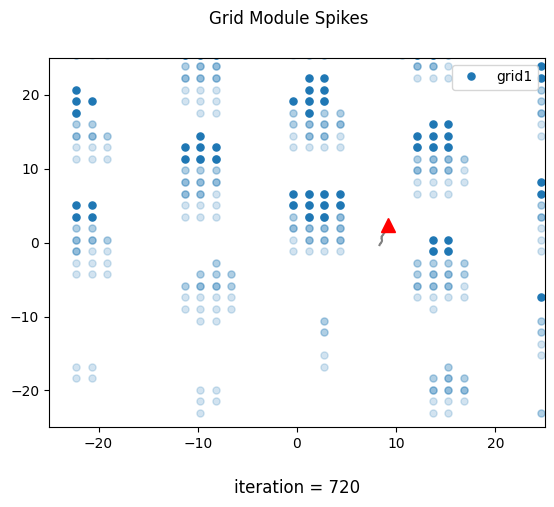

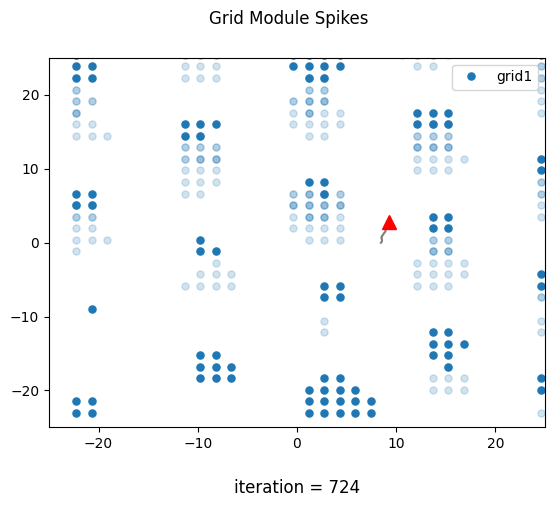

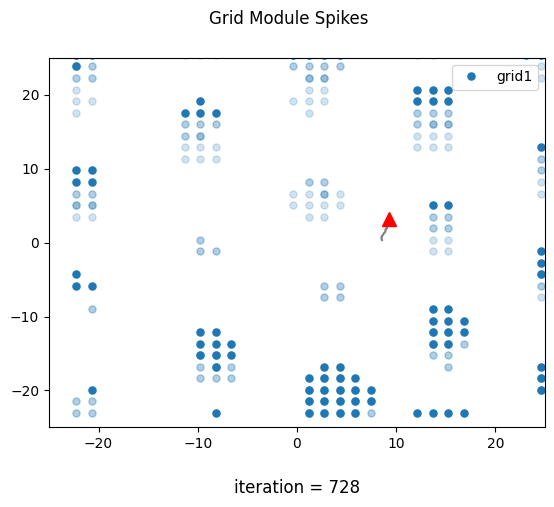

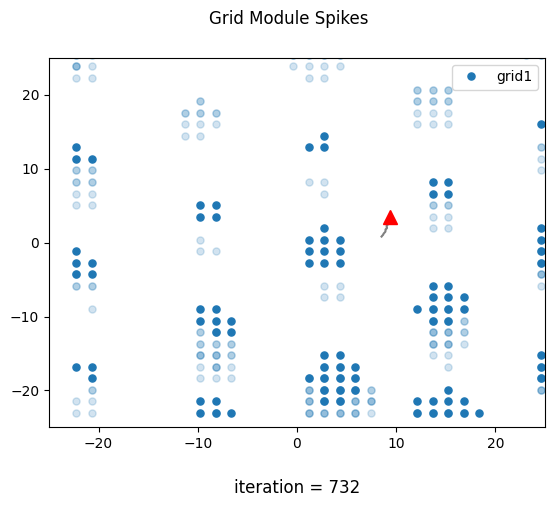

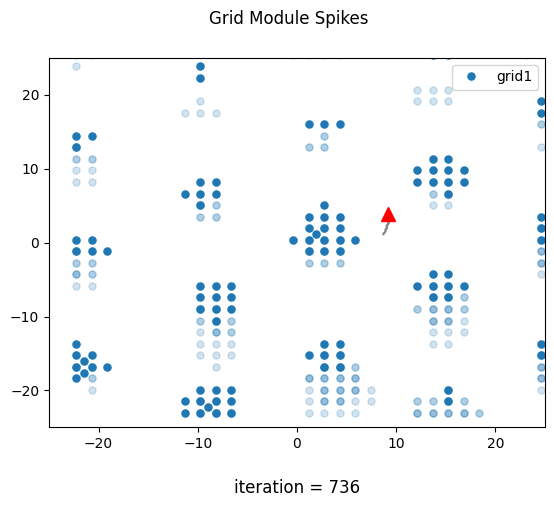

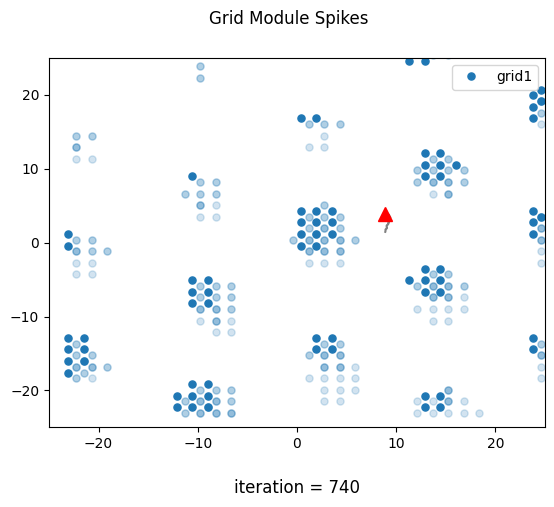

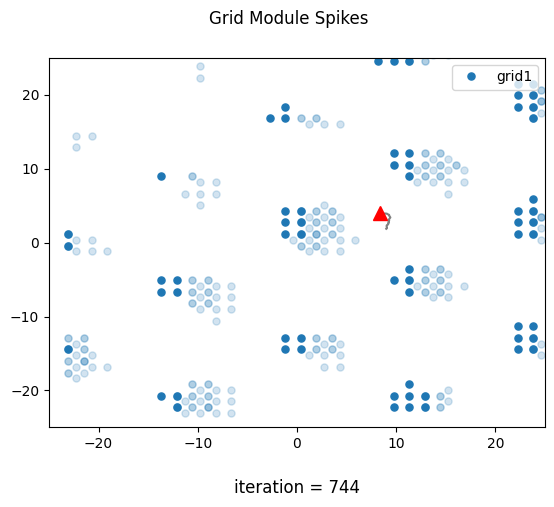

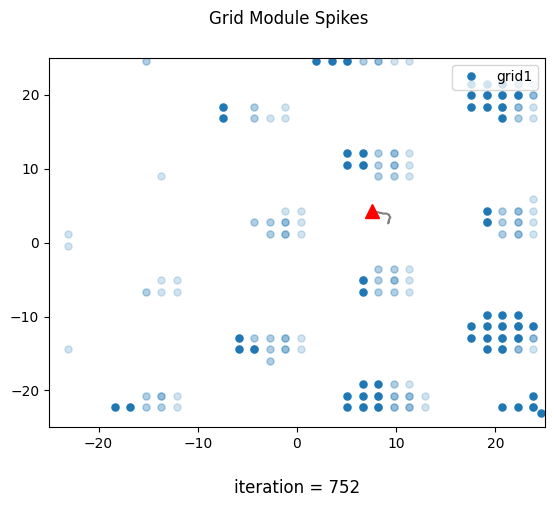

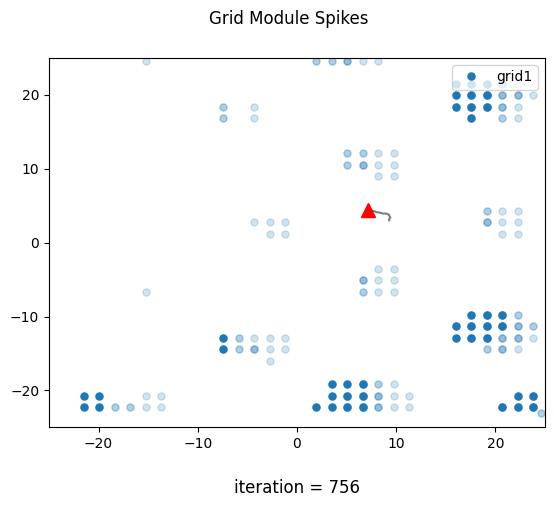

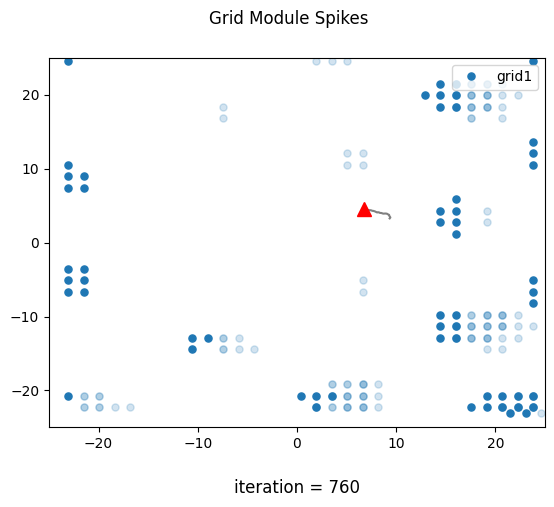

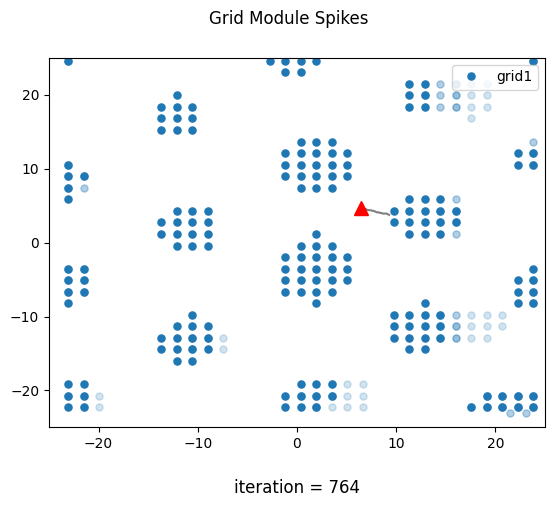

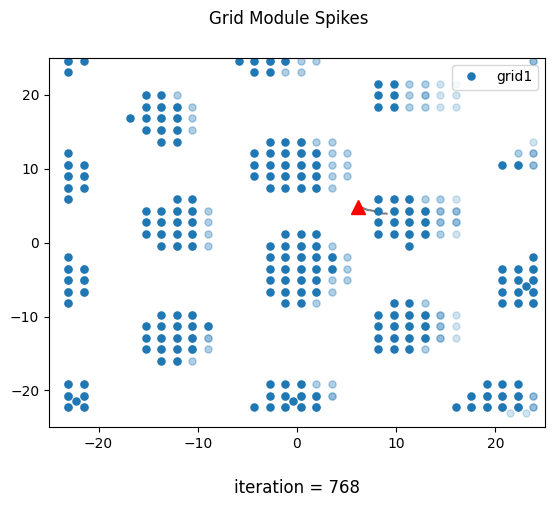

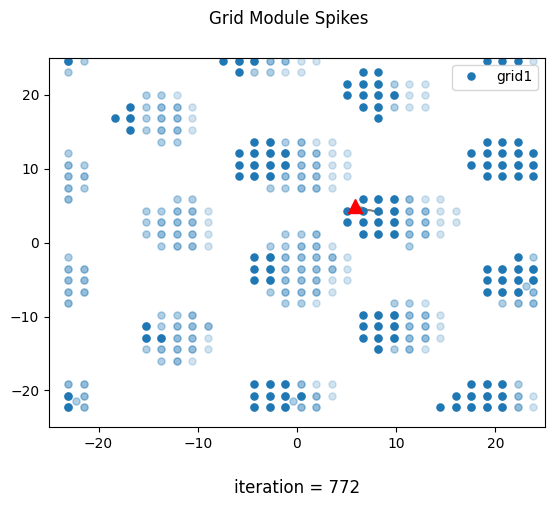

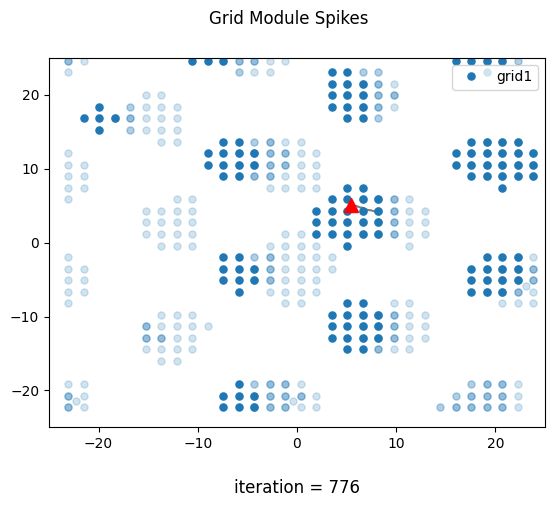

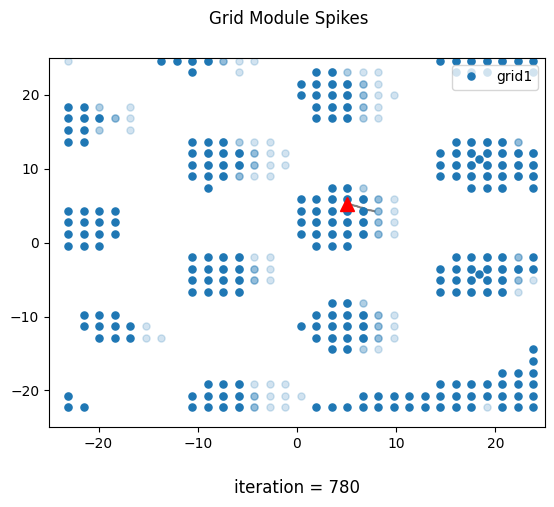

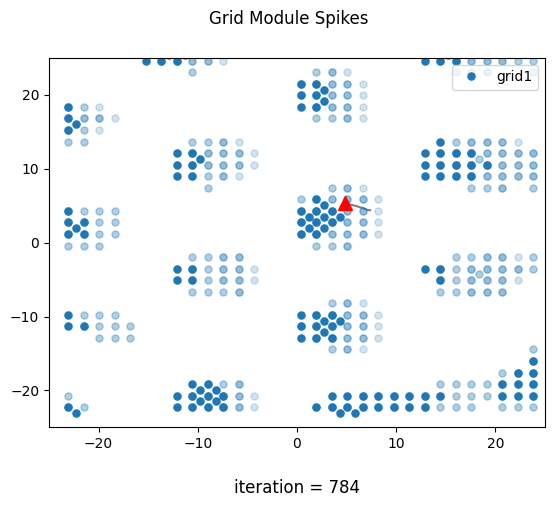

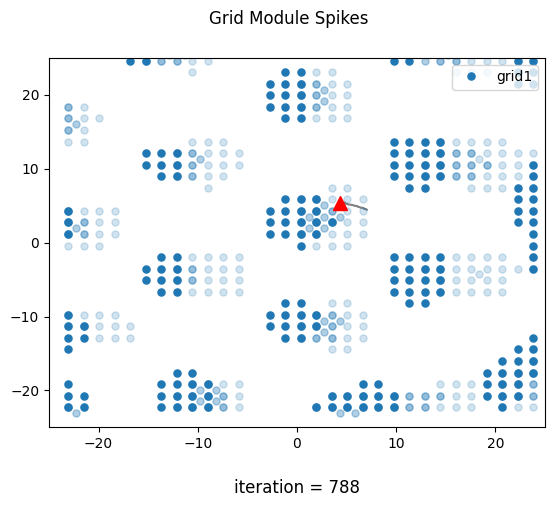

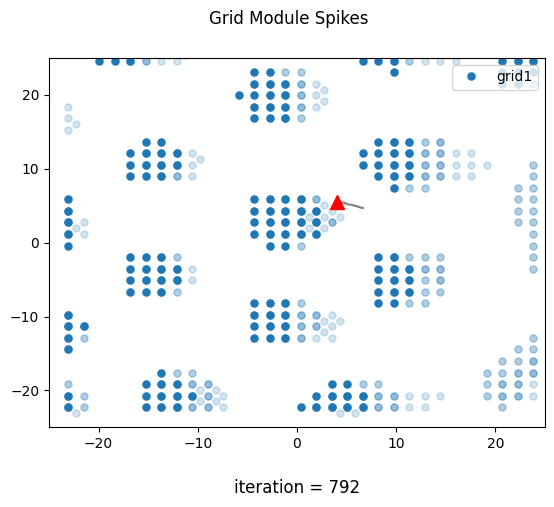

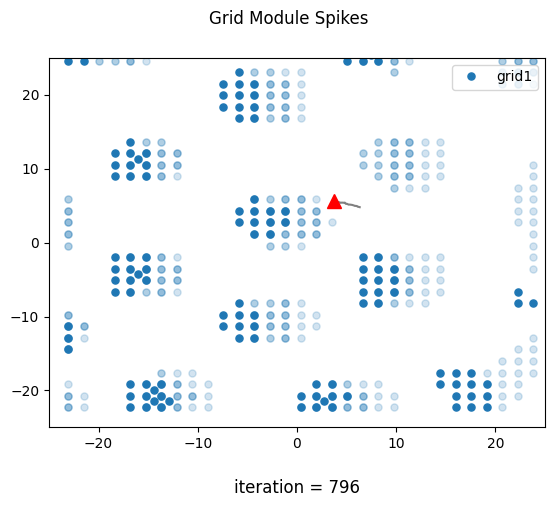

In [1480]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = list(prop_cycle.by_key()['color'])

offset_x = [+2, +2.5, +2.25]
offset_y = [+2, -10.5, -10.25]
for i in range(150, 200) :
    cnt = 0
    for ng in ngs : 
        iter_spike_multi(ng,
            itr = i, 
            step = 4, 
            color = colors[cnt], 
            save = False, 
            lib = "noise", 
            label = "grid" + str(cnt + 1), 
            offset_x = offset_x[cnt], 
            offset_y = offset_y[cnt],
            base_offset_x = 0,
            base_offset_y = 0
            )
        cnt += 1
        
    plt.show()